Import delle librerie

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Caricamento del dataset in un DataFrame `pandas` e visualizzazione delle prime 5 righe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Statistical Methods/emails.csv')
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


Elimino la colonna con l'identificativo delle e-mail e conto le istanze che presentano come variabile target 0 (non spam) e 1 (spam)

In [ ]:
df.drop(columns=['Email No.'], inplace=True)
df['Prediction'].value_counts()

0    3672
1    1500
Name: Prediction, dtype: int64

Il dataset non è fortemente sbilanciato, è possibile procedere con l'analisi delle features, dati mancanti e outliers

In [ ]:
print("null values:")
sum(df.isna().sum())

null values:


0

Non vi sono dati mancanti all'interno del dataset, ma è possibile notare l'elevato numero di outlier per ogni feature. Tuttavia, si ritiene non utile l'eliminazione di questi ultimi in quanto rappresentano la maggiorparte dei valori e portatori di significato.

In [ ]:
X = df.drop('Prediction', axis=1).values
Y = df['Prediction'].values

Si procede con la suddivisione del dataset in train dataset e test dataset tramite hold-out, riservando l'80% dei sample per il training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Logistic Regression

Applicazione di z-score normalization su train e test dataset

In [ ]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

Il modello `SGDClassifier` della libreria `scikit-learn` è allenato con sul train dataset mantenendo i paramtri di default. Il modello implementa la Logistic Regression utilizzando Stochastic Gradient Descent

In [ ]:
model = SGDClassifier(random_state=42)
model.fit(x_train_sc, y_train)

SGDClassifier(random_state=42)

Predizione sul test datset e risultati

In [ ]:
y_preds = model.predict(x_test_sc)
print(f"Classification Report:")
print(classification_report(y_test, y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       739
           1       0.98      0.82      0.90       296

    accuracy                           0.94      1035
   macro avg       0.96      0.91      0.93      1035
weighted avg       0.95      0.94      0.94      1035



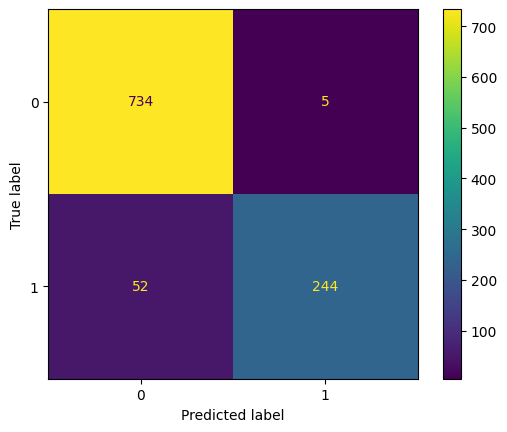

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

Il modello si comporta molto bene (recall > 0.9), inoltre i false positive (mail classificate come spam che sono in realtà non spam) sono minori dei false negative (mail classificate come non spam che sono in realtà sono spam). Nei blocchi successivi si prova ad incrementare le performance del modello.

## With PCA

Di seguito si applica la PCA (Principal Component Analysis) per poter ridurre la dimensione delle features trattenendo un certa percentuale di varianza. Nella tabella sono mostrati i numeri di componenti per poter ritenere una varianza almeno dell'80% (0.8)

In [ ]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

pca = PCA(random_state=42)

pca.fit(x_train_sc)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

pca_results = pd.DataFrame({
    "component": [i+1 for i in range(0, len(cum_var_exp))],
    "cumulative_variance": [var for var in cum_var_exp]
})

exp_var_threshold = 0.8

valid_pca_results = pca_results[pca_results['cumulative_variance'] > exp_var_threshold]

print(f"Components with cumulative variance over threshold of {exp_var_threshold}")
valid_pca_results.head()

Components with cumulative variance over threshold of 0.8


,component,cumulative_variance
439,440,0.800000
440,441,0.800517
441,442,0.801033
442,443,0.801548
443,444,0.802061


Dalla tabella risulta che sono necessarie 440 componenti

In [ ]:
n_components = int(valid_pca_results.iloc[0]["component"])
print(f"Selected components: {n_components}")

Selected components: 440


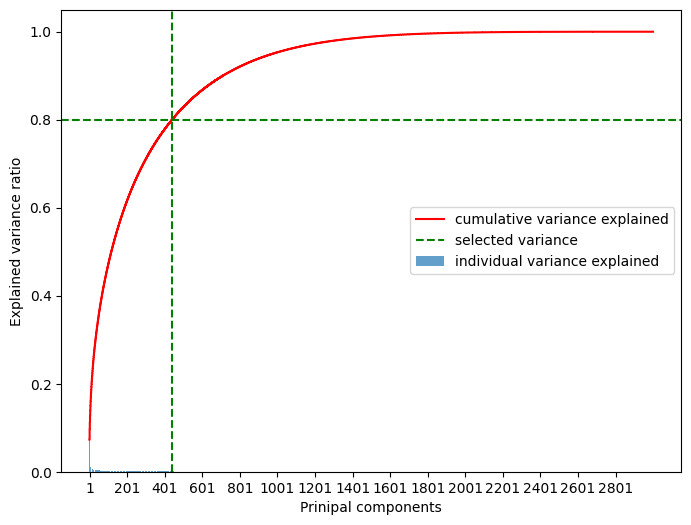

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cum_var_exp) + 1), var_exp, align="center", label="individual variance explained", alpha=0.7)
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where="mid", label="cumulative variance explained", color="red")
plt.ylabel("Explained variance ratio")
plt.xlabel("Prinipal components")
plt.xticks(np.arange(1, len(var_exp) + 1, 200))

plt.axhline(y=valid_pca_results.iloc[0]["cumulative_variance"], color='g', linestyle='--', label="selected variance")
plt.axvline(x=n_components, color='g', linestyle='--')

plt.legend(loc="center right")

plt.show()

Di seguito è applicata la PCA riducendo il train e test dataset a 440 componenti riallenando l'`SGDClassifier`

In [ ]:
pca = PCA(n_components=n_components, random_state=42)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

In [ ]:
model = SGDClassifier(random_state=42)
model.fit(x_train_pca, y_train)

SGDClassifier(random_state=42)

In [ ]:
y_preds = model.predict(x_test_pca)
print(f"Classification Report:")
print(classification_report(y_test, y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       739
           1       0.96      0.86      0.91       296

    accuracy                           0.95      1035
   macro avg       0.95      0.92      0.94      1035
weighted avg       0.95      0.95      0.95      1035



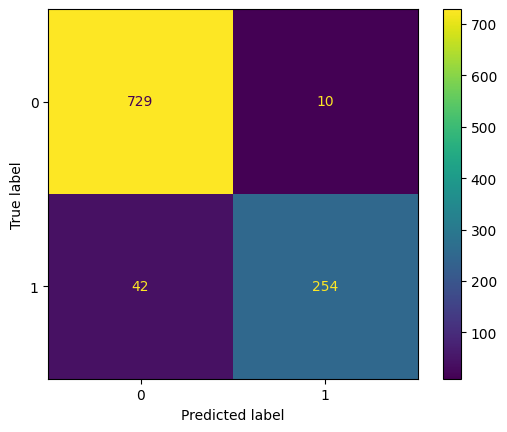

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

I risultati, in generale, sono migliorati ma il numero di false positive è aumentato

## GridSearch and KFold

Cercando di migliorare ancora i risultati, si effettua una Grid Search con Cross Validation, selezionando come parametri:
- `pca__n_components`: numero di componenenti
- `model__alpha`: coefficiente di regolarizzazione
- `model__penalty`: tipo di regolarizzazione
- `model__eta0`: learning rate

Il train dataset è suddiviso in 5 fold, 1 fold alla voltà verrà usato come validation set e i restanti 4 come train dataset. Per ognuna di queste combinazioni (comprese le combinazioni dei parametri) si effettuerà il training per poi prelevare i parametri che hanno restituito un'accuracy migliore

In [ ]:
sc = StandardScaler()
pca = PCA(random_state=42)
model = SGDClassifier(loss='log_loss', learning_rate='constant', random_state=42)

steps = [
    ("scaler", sc),
    ("pca", pca),
    ("model", model)
]

pipe = Pipeline(steps)

folds = KFold(n_splits=5, shuffle=True, random_state=42)


params = {
    "pca__n_components": list(np.arange(300, 500, 50)),
    "model__alpha": [0.1, 1, 10, 100], # lmd
    "model__penalty": ["l1", "l2"],
    "model__eta0": [1e-4, 1e-3, 1e-2, 1e-1] #lr
}

In [ ]:
search = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=folds,
    scoring="accuracy",
    verbose=3,
    return_train_score=True
  )

search.fit(x_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=300;, score=(train=0.827, test=0.807) total time=   4.4s
[CV 2/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=300;, score=(train=0.843, test=0.871) total time=   4.0s
[CV 3/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=300;, score=(train=0.841, test=0.819) total time=   3.9s
[CV 4/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=300;, score=(train=0.843, test=0.826) total time=   3.2s
[CV 5/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=300;, score=(train=0.824, test=0.839) total time=   3.8s
[CV 1/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l1, pca__n_components=350;, score=(train=0.827, test=0.807) total time=   3.9s
[CV 2/5] END model__alpha=0.1, model__eta0=0.0001, model__penalty=l

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('model',
                                        SGDClassifier(learning_rate='constant',
                                                      loss='log_loss',
                                                      random_state=42))]),
             param_grid={'model__alpha': [0.1, 1, 10, 100],
                         'model__eta0': [0.0001, 0.001, 0.01, 0.1],
                         'model__penalty': ['l1', 'l2'],
                         'pca__n_components': [300, 350, 400, 450]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [ ]:
best_score = search.best_score_
best_params = search.best_params_

print(f"The highest test accuracy is {best_score} with {best_params}")

The highest test accuracy is 0.9545543229997255 with {'model__alpha': 0.1, 'model__eta0': 0.001, 'model__penalty': 'l2', 'pca__n_components': 450}


Si procede con l'ultimo training passando al modello e alla pca i parametetri migliori utilizzando l'intero train dataset

In [ ]:
sc = StandardScaler()
best_pca = PCA(n_components=best_params["pca__n_components"], random_state=42)
best_model = SGDClassifier(learning_rate="constant", eta0=best_params["model__eta0"], alpha=best_params["model__alpha"], penalty=best_params["model__penalty"], random_state=42)

x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)
joblib.dump(sc, 'scaler.joblib')

x_train_pca = best_pca.fit_transform(x_train_sc)
x_test_pca = best_pca.transform(x_test_sc)
joblib.dump(best_pca, 'best_pca.joblib')

best_model.fit(x_train_pca, y_train)
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [ ]:
y_preds = best_model.predict(x_test_pca)
print(f"Classification Report:")
print(classification_report(y_test, y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       739
           1       0.94      0.98      0.96       296

    accuracy                           0.97      1035
   macro avg       0.96      0.98      0.97      1035
weighted avg       0.98      0.97      0.98      1035



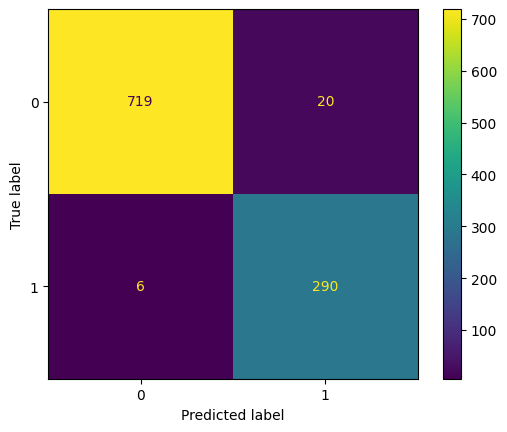

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

L'accuracy è migliorata, ma i false positive sono aumentati rispetto al primo caso

## Custom Logistic Regression

Utilizzando i paramtri trovati in precedenza, si testa il funzionamento di una implementazione custom dell' `SGDClassifier`

In [ ]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

class LogisticRegression:

  def __init__(self, learning_rate=1e-2, n_steps=200, n_features=1, lmd=1):
    self.n_features = n_features + 1
    self.learning_rate = learning_rate
    self.n_steps = n_steps
    self.theta = np.random.rand(self.n_features)
    self.lmd = lmd

  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def fit(self, X, y, X_test, y_test):
    m = len(X)
    X = np.c_[np.ones(X.shape[0]), X]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    cost_history = np.zeros(self.n_steps)
    cost_history_test = np.zeros(self.n_steps)

    for step in range(0, self.n_steps):
      preds = self.sigmoid(np.dot(X, self.theta))
      preds_test = self.sigmoid(np.dot(X_test, self.theta))

      for sample in range(0, m):
        old_theta = self.theta
        self.theta = old_theta - (self.learning_rate * (self.sigmoid(old_theta * X[sample]) - y[sample]) * X[sample])
        self.theta[1:] = self.theta[1:] - (self.learning_rate * self.lmd * old_theta[1:])

      #print(preds, y, np.log(preds))
      cost_history[step] = - (1 / m) * (np.dot(y.T, np.log(preds)) + np.dot((1 - y).T, np.log(1 - preds))) + (self.lmd / (2*m)) * np.sum(np.square(self.theta[1:]))
      cost_history_test[step] = - (1 / m) * (np.dot(y_test.T, np.log(preds_test)) + np.dot((1 - y_test).T, np.log(1 - preds_test))) + (self.lmd / (2*m)) * np.sum(np.square(self.theta[1:]))

    return cost_history, cost_history_test

  def predict(self, X):
    Xpred = np.c_[np.ones(X.shape[0]), X]
    a = self.sigmoid(np.dot(Xpred, self.theta))
    return np.round(a)

In [ ]:
sc = StandardScaler()
best_pca = PCA(n_components=best_params["pca__n_components"], random_state=42)

x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

x_train_pca = best_pca.fit_transform(x_train_sc)
x_test_pca = best_pca.transform(x_test_sc)

model = LogisticRegression(learning_rate=best_params["model__eta0"], lmd=best_params["model__alpha"], n_features=x_train_pca.shape[1], n_steps=50)
cost_history, cost_history_test = model.fit(x_train_pca, y_train, x_test_pca, y_test)

Nel grafico è rappresentato l'andamento della loss attraverso le varie epoche di training

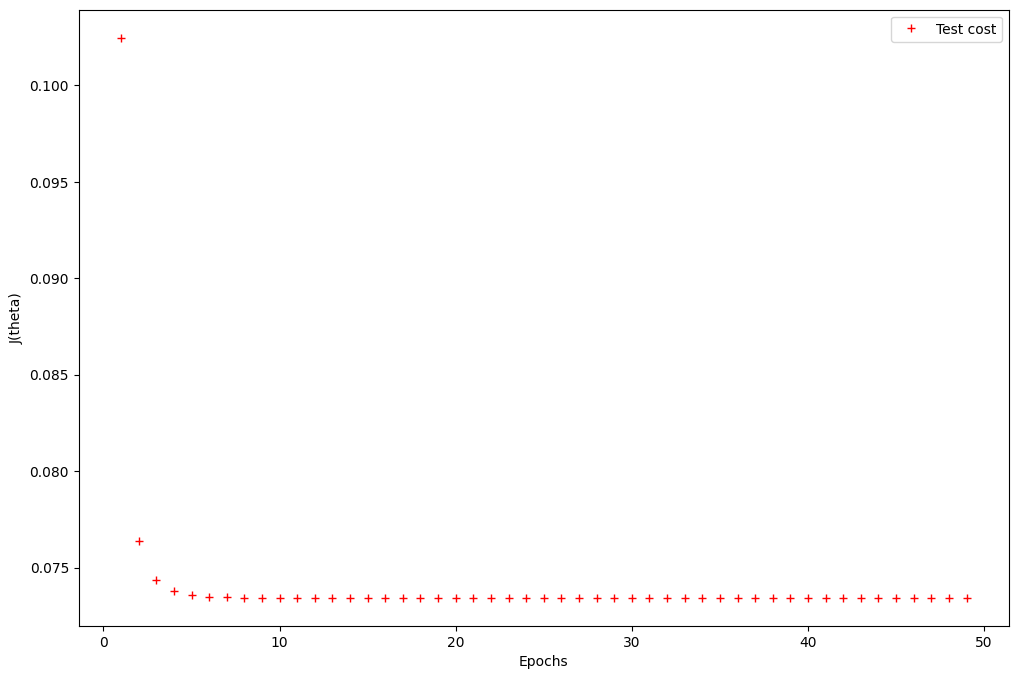

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylabel('J(theta)')
ax.set_xlabel('Epochs')
cv, = ax.plot(range(model.n_steps), cost_history_test, 'r+')
cv.set_label('Test cost')
ax.legend()

plt.show()

In [ ]:
y_preds = model.predict(x_test_pca)
print(f"Classification Report:")
print(classification_report(y_test, y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       739
           1       0.90      0.80      0.85       296

    accuracy                           0.92      1035
   macro avg       0.91      0.88      0.90      1035
weighted avg       0.92      0.92      0.92      1035



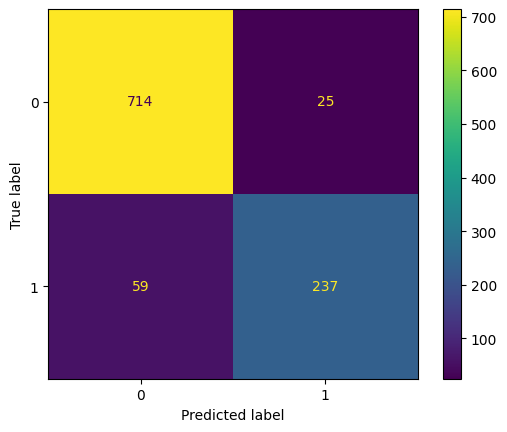

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

I risultati ottenuti non sono molto distanti dai migliori ottenuti in precedenza